In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [252]:
n = 100
d = 50
split_size = 0.2 # proportion of datapoints for test set

f = lambda x: (5*x[0]) + (2*x[1]) + (10*x[2])

X_train = np.random.normal(size=(int(n*(1-split_size)),d))
X_test = np.random.normal(size=(int(n*split_size),d))
y_train = np.array([f(x) for x in X_train])
y_test = np.array([f(x) for x in X_test])

In [253]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 50), (20, 50), (80,), (20,))

In [254]:
X_train[0]

array([-0.52775717,  1.65142242,  0.76634402,  0.96988638,  1.04112923,
       -0.08681719, -0.84309508, -1.42302206, -0.52556384,  0.34554332,
       -0.02740217,  0.73611816, -1.14250122, -1.20608004,  1.43823145,
       -0.28131904, -0.57987247, -1.26854129, -1.14421025,  0.52936592,
        0.86496903, -0.85628583, -0.81598277, -0.58297765,  0.54589084,
        0.50715295,  0.42986542, -0.52392805, -0.56136854, -0.45236671,
        0.90225308, -0.91485163, -0.57745489, -0.79017638, -0.90502085,
       -0.29250253,  1.53488455, -0.33064942,  0.59709578,  1.2886424 ,
       -1.28015148, -1.54640869, -1.81434618,  0.0665454 , -0.20472855,
       -1.07591172,  1.43858028, -0.82254503, -0.38948706, -0.144924  ])

In [255]:
y_train[0]

8.327499195177756

In [256]:
def mnorm(x, z, M, squared=True): # (n, d), (m,d), (d,d) --> (n, m)
    # implements |x-z|_M^2 between pairs from x and z
    x_norm = ((x @ M)*x).sum(axis=1, keepdims=True)
    if x is z:
        z_norm = x_norm
    else:
        z_norm = ((z @ M)*z).sum(axis=1, keepdims=True)
        
    z_norm = z_norm.reshape(1, -1)
    
    distances = (x @ (M @ z.T)*-2) + x_norm + z_norm
    if not squared:
        distances = np.sqrt(np.clip(distances, 0, np.inf))
    return distances

In [257]:
M = np.eye(d)

mnorm(X_train, X_train, M, squared=False)

array([[0.00000000e+00, 9.43104400e+00, 7.93137684e+00, ...,
        9.76619723e+00, 8.35183436e+00, 9.99799921e+00],
       [9.43104400e+00, 0.00000000e+00, 9.82977633e+00, ...,
        9.42812754e+00, 9.49553596e+00, 8.99394415e+00],
       [7.93137684e+00, 9.82977633e+00, 1.19209290e-07, ...,
        1.04284196e+01, 9.10048249e+00, 9.30797960e+00],
       ...,
       [9.76619723e+00, 9.42812754e+00, 1.04284196e+01, ...,
        1.68587394e-07, 1.04122862e+01, 9.92430431e+00],
       [8.35183436e+00, 9.49553596e+00, 9.10048249e+00, ...,
        1.04122862e+01, 0.00000000e+00, 9.15186069e+00],
       [9.99799921e+00, 8.99394415e+00, 9.30797960e+00, ...,
        9.92430431e+00, 9.15186069e+00, 0.00000000e+00]])

In [258]:
def K_M(x, z, M, L):
    pairwise_distances = mnorm(x, z, M, squared=False)
    pairwise_distances = np.clip(pairwise_distances, 0, np.inf)
    return np.exp(pairwise_distances * -(1./L))

def grad_laplace_mat(a, x, z, M, L): # (n, d), (m, d), (d, d) --> (n, m, d)
    dist = mnorm(x, z, M, squared=False)
    dist = np.where(dist < 1e-4, np.zeros(1, dtype=np.float16), dist)
    
    K = K_M(x, z, M, L)/dist
    K[K == float('inf')] = 0.
    
    a = a[:, None]
    
    n, d = x.shape
    n, c = a.shape
    m, d = z.shape
    
    a = a.reshape(n, c, 1)
    X1 = (x @ M).reshape(n, 1, d)
    step1 = (a @ X1).reshape(-1, c*d)
    
    step2 = (K.T @ step1).reshape(-1, c, d)
    del step1
    
    step3 = ((a.T @ K).T).reshape(m, c, 1)
    z1 = (z @ M).reshape(m, 1, d)
    step3 = step3 @ z1
    
    G = (step2 - step3) * -1/L
    
    return G
    
    # nm_factor = np.where(
    #     mnorm(x, z, M) < 1e-4, 0, K_M(x, z, M, L)/mnorm(x, z, M, squared=False)/L)
    # np.fill_diagonal(nm_factor, 0.)
    # return ((z @ M) - (x @ M)[:,None,:]) * nm_factor[:,:,None]

In [259]:
T = 10
L = 1.
M = np.eye(d)

for t in range(T):
    K_train = K_M(X_train, X_train, M, L=L)
    alpha = y_train @ np.linalg.pinv(K_train)
    grad = grad_laplace_mat(alpha, X_train, X_train, M, L=L)
    M = np.mean(np.swapaxes(grad, 1, 2) @ grad, axis=0)

/var/folders/mc/421h_39x625fpy09_jss5vrh0000gn/T/ipykernel_79221/1190691096.py:10: RuntimeWarning: divide by zero encountered in true_divide
  K = K_M(x, z, M, L)/dist


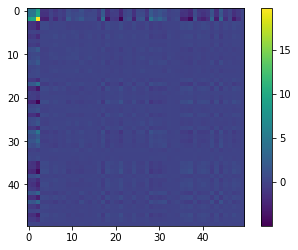

In [260]:
plt.imshow(M)
plt.colorbar()

In [261]:
y_pred_train = alpha @ K_M(X_train, X_train, M, L)
((y_train - y_pred_train)**2).mean()

0.016238761057666175

In [262]:
y_pred_test = alpha @ K_M(X_train, X_test, M, L)
((y_test - y_pred_test)**2).mean()

148.7228275899262